In [5]:
!pip install tf-explain

In [6]:
!pip install --upgrade tensorflow

In [7]:
!pip install opencv-python

In [8]:
# common
import os
import keras
import numpy as np
import pandas as pd
from glob import glob
import tensorflow as tf
import tensorflow.image as tfi

# Data
from keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.utils import to_categorical

# Data Viz
import matplotlib.pyplot as plt

# Model
from keras.models import Model
from keras.layers import Layer
from keras.layers import Conv2D
from keras.layers import Dropout
from keras.layers import UpSampling2D
from keras.layers import concatenate
from keras.layers import Add
from keras.layers import Multiply
from keras.layers import Input
from keras.layers import MaxPool2D
from keras.layers import BatchNormalization

# Callbacks
from keras.callbacks import Callback
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from tf_explain.core.grad_cam import GradCAM

# Metrics
from keras.metrics import MeanIoU

In [9]:
def load_image(image, SIZE):
    return np.round(tfi.resize(img_to_array(load_img(image))/255.,(SIZE, SIZE)),4)

def load_images(image_paths, SIZE, mask=False, trim=None):
    if trim is not None:
        image_paths = image_paths[:trim]

    if mask:
        images = np.zeros(shape=(len(image_paths), SIZE, SIZE, 1))
    else:
        images = np.zeros(shape=(len(image_paths), SIZE, SIZE, 3))

    for i,image in enumerate(image_paths):
        img = load_image(image,SIZE)
        if mask:
            images[i] = img[:,:,:1]
        else:
            images[i] = img

    return images

In [10]:
def show_image(image, title=None, cmap=None, alpha=1):
    plt.imshow(image, cmap=cmap, alpha=alpha)
    if title is not None:
        plt.title(title)
    plt.axis('off')

def show_mask(image, mask, cmap=None, alpha=0.4):
    plt.imshow(image)
    plt.imshow(tf.squeeze(mask), cmap=cmap, alpha=alpha)
    plt.axis('off')

In [11]:
SIZE = 256

In [12]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [13]:
root_path='/content/drive/MyDrive/Dataset_BUSI_with_GT'

In [14]:
import os
classes = sorted(os.listdir(root_path))
print(classes)

['.DS_Store', 'benign', 'malignant', 'normal']


In [15]:
single_mask_paths = sorted([sorted(glob(root_path + name + "/*mask.png")) for name in classes])
double_mask_paths = sorted([sorted(glob(root_path + name + "/*mask_1.png")) for name in classes])

In [16]:
image_paths = []
mask_paths = []
for class_path in single_mask_paths:
    for path in class_path:
        img_path = path.replace('_mask','')
        image_paths.append(img_path)
        mask_paths.append(path)

In [17]:
print("Number of images found:", len(image_paths))
print("Image paths:", image_paths)

Number of images found: 0
Image paths: []


In [18]:
import os

root_path = "/content/drive/MyDrive/Dataset_BUSI_with_GT"

if os.path.exists(root_path):
    print("Dataset directory exists!")
    print("Contents:", os.listdir(root_path))  # List the contents
else:
    print("Dataset directory NOT found! Check your path.")

Dataset directory exists!
Contents: ['.DS_Store', 'benign', 'malignant', 'normal']


In [19]:
!ls -R "/content/drive/MyDrive/Dataset_BUSI_with_GT"

/content/drive/MyDrive/Dataset_BUSI_with_GT:
benign	malignant  normal

/content/drive/MyDrive/Dataset_BUSI_with_GT/benign:
'benign (100)_mask_1.png'  'benign (231).png'	      'benign (364).png'
'benign (100)_mask.png'    'benign (232)_mask.png'    'benign (365)_mask.png'
'benign (100).png'	   'benign (232).png'	      'benign (365).png'
'benign (101)_mask.png'    'benign (233)_mask.png'    'benign (366)_mask.png'
'benign (101).png'	   'benign (233).png'	      'benign (366).png'
'benign (102)_mask.png'    'benign (234)_mask.png'    'benign (367)_mask.png'
'benign (102).png'	   'benign (234).png'	      'benign (367).png'
'benign (103)_mask.png'    'benign (235)_mask.png'    'benign (368)_mask.png'
'benign (103).png'	   'benign (235).png'	      'benign (368).png'
'benign (104)_mask.png'    'benign (236)_mask.png'    'benign (369)_mask.png'
'benign (104).png'	   'benign (236).png'	      'benign (369).png'
'benign (105)_mask.png'    'benign (237)_mask.png'    'benign (36)_mask.png'
'benign (

In [20]:
from glob import glob

image_paths = glob(os.path.join(root_path, "**/*.png"), recursive=True)  # Adjust extension if needed
print("Total images found:", len(image_paths))

Total images found: 1578


In [21]:
image_paths = glob(os.path.join(root_path, "**/*.*"), recursive=True)  # Finds all files

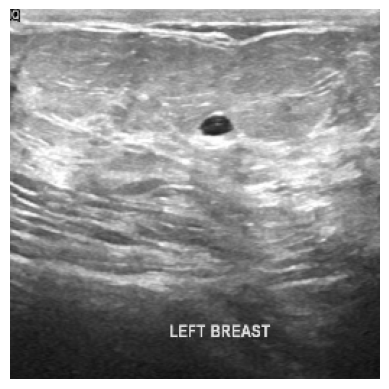

In [22]:
if image_paths:
    show_image(load_image(image_paths[0], SIZE))
else:
    print(" No images found! Check dataset path and file extensions.")

In [23]:
from glob import glob  # This must be at the top

# Define mask dataset path
mask_root_path = "/content/drive/MyDrive/Dataset_BUSI_with_GT/"  # Adjust if needed

# Find all mask images
mask_paths = glob(os.path.join(mask_root_path, "**/*mask*.png"), recursive=True)  # Adjust extension if needed

# Print mask details
print("Total masks found:", len(mask_paths))
print("Sample masks:", mask_paths[:5])

Total masks found: 798
Sample masks: ['/content/drive/MyDrive/Dataset_BUSI_with_GT/benign/benign (104)_mask.png', '/content/drive/MyDrive/Dataset_BUSI_with_GT/benign/benign (100)_mask.png', '/content/drive/MyDrive/Dataset_BUSI_with_GT/benign/benign (100)_mask_1.png', '/content/drive/MyDrive/Dataset_BUSI_with_GT/benign/benign (102)_mask.png', '/content/drive/MyDrive/Dataset_BUSI_with_GT/benign/benign (10)_mask.png']


In [24]:
import os

mask_root_path = "/content/drive/MyDrive/Dataset_BUSI_with_GT"

if os.path.exists(mask_root_path):
    print("Mask directory exists!")
    print("Contents:", os.listdir(mask_root_path))  # List available subfolders
else:
    print("Mask directory NOT found! Check your path.")

Mask directory exists!
Contents: ['.DS_Store', 'benign', 'malignant', 'normal']


In [25]:
!ls -R "/content/drive/MyDrive/Dataset_BUSI_with_GT"

/content/drive/MyDrive/Dataset_BUSI_with_GT:
benign	malignant  normal

/content/drive/MyDrive/Dataset_BUSI_with_GT/benign:
'benign (100)_mask_1.png'  'benign (231).png'	      'benign (364).png'
'benign (100)_mask.png'    'benign (232)_mask.png'    'benign (365)_mask.png'
'benign (100).png'	   'benign (232).png'	      'benign (365).png'
'benign (101)_mask.png'    'benign (233)_mask.png'    'benign (366)_mask.png'
'benign (101).png'	   'benign (233).png'	      'benign (366).png'
'benign (102)_mask.png'    'benign (234)_mask.png'    'benign (367)_mask.png'
'benign (102).png'	   'benign (234).png'	      'benign (367).png'
'benign (103)_mask.png'    'benign (235)_mask.png'    'benign (368)_mask.png'
'benign (103).png'	   'benign (235).png'	      'benign (368).png'
'benign (104)_mask.png'    'benign (236)_mask.png'    'benign (369)_mask.png'
'benign (104).png'	   'benign (236).png'	      'benign (369).png'
'benign (105)_mask.png'    'benign (237)_mask.png'    'benign (36)_mask.png'
'benign (

In [26]:
from glob import glob

# Adjust the path if masks are stored in a specific subfolder
mask_paths = glob(os.path.join(mask_root_path, "**/*mask*.png"), recursive=True)  # Change extension if needed

print("Total masks found:", len(mask_paths))
print("Sample masks:", mask_paths[:5])

Total masks found: 798
Sample masks: ['/content/drive/MyDrive/Dataset_BUSI_with_GT/benign/benign (104)_mask.png', '/content/drive/MyDrive/Dataset_BUSI_with_GT/benign/benign (100)_mask.png', '/content/drive/MyDrive/Dataset_BUSI_with_GT/benign/benign (100)_mask_1.png', '/content/drive/MyDrive/Dataset_BUSI_with_GT/benign/benign (102)_mask.png', '/content/drive/MyDrive/Dataset_BUSI_with_GT/benign/benign (10)_mask.png']


In [27]:
mask_paths = glob(os.path.join(mask_root_path, "**/*.*"), recursive=True)  # Finds all files

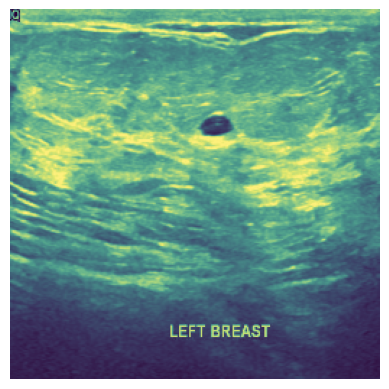

In [28]:
if image_paths and mask_paths:
    show_mask(load_image(image_paths[0], SIZE), load_image(mask_paths[0], SIZE)[:, :, 0], alpha=0.6)
else:
    print("No images or masks found! Check dataset path and file names.")

In [29]:
import os

dataset_path = "/content/drive/MyDrive/Dataset_BUSI_with_GT/"

if os.path.exists(dataset_path):
    print("Dataset directory exists!")
    print("Contents:", os.listdir(dataset_path))  # List files and folders
else:
    print("Dataset directory NOT found! Check your path.")

Dataset directory exists!
Contents: ['.DS_Store', 'benign', 'malignant', 'normal']


In [30]:
!ls -R "/content/drive/MyDrive/Dataset_BUSI_with_GT/"

/content/drive/MyDrive/Dataset_BUSI_with_GT/:
benign	malignant  normal

/content/drive/MyDrive/Dataset_BUSI_with_GT/benign:
'benign (100)_mask_1.png'  'benign (231).png'	      'benign (364).png'
'benign (100)_mask.png'    'benign (232)_mask.png'    'benign (365)_mask.png'
'benign (100).png'	   'benign (232).png'	      'benign (365).png'
'benign (101)_mask.png'    'benign (233)_mask.png'    'benign (366)_mask.png'
'benign (101).png'	   'benign (233).png'	      'benign (366).png'
'benign (102)_mask.png'    'benign (234)_mask.png'    'benign (367)_mask.png'
'benign (102).png'	   'benign (234).png'	      'benign (367).png'
'benign (103)_mask.png'    'benign (235)_mask.png'    'benign (368)_mask.png'
'benign (103).png'	   'benign (235).png'	      'benign (368).png'
'benign (104)_mask.png'    'benign (236)_mask.png'    'benign (369)_mask.png'
'benign (104).png'	   'benign (236).png'	      'benign (369).png'
'benign (105)_mask.png'    'benign (237)_mask.png'    'benign (36)_mask.png'
'benign 

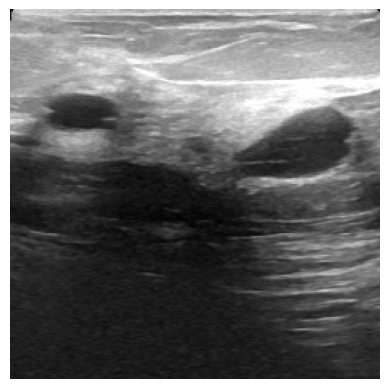

In [31]:
image_path = "/content/drive/MyDrive/Dataset_BUSI_with_GT/benign/benign (100).png"  # Change filename accordingly
show_image(load_image(image_path, SIZE))

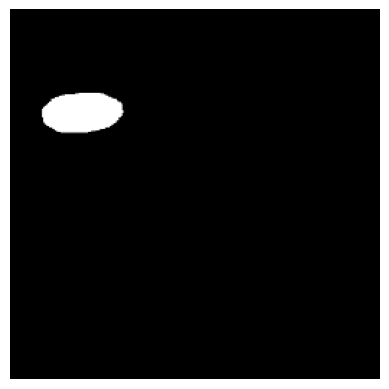

In [32]:
show_image(load_image('/content/drive/MyDrive/Dataset_BUSI_with_GT/benign/benign (100)_mask_1.png', SIZE))

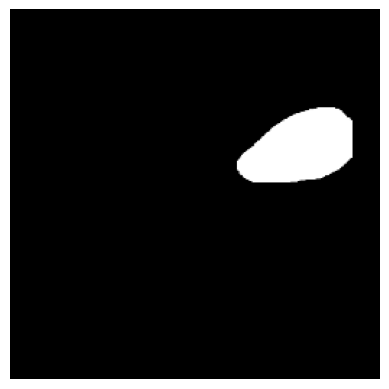

In [33]:
show_image(load_image('/content/drive/MyDrive/Dataset_BUSI_with_GT/benign/benign (100)_mask.png', SIZE))

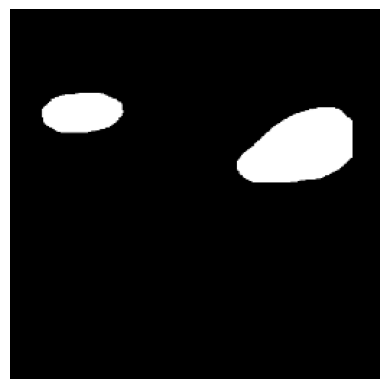

In [34]:
img = np.zeros((1,SIZE,SIZE,3))
mask1 = load_image('/content/drive/MyDrive/Dataset_BUSI_with_GT/benign/benign (100)_mask_1.png', SIZE)
mask2 = load_image('/content/drive/MyDrive/Dataset_BUSI_with_GT/benign/benign (100)_mask.png', SIZE)

img = img + mask1 + mask2
img = img[0,:,:,0]
show_image(img, cmap='gray')

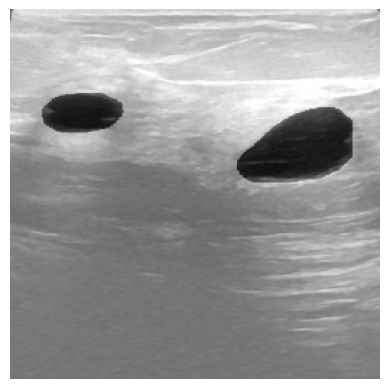

In [35]:
show_image(load_image('/content/drive/MyDrive/Dataset_BUSI_with_GT/benign/benign (100).png', SIZE))
plt.imshow(img, cmap='binary', alpha=0.4)
plt.axis('off')
plt.show()

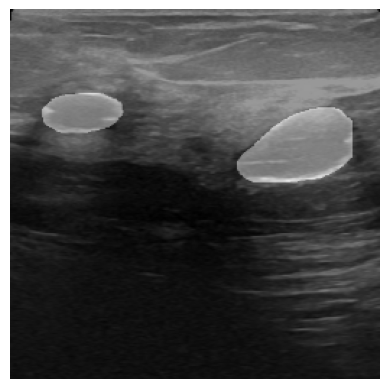

In [36]:
show_image(load_image('/content/drive/MyDrive/Dataset_BUSI_with_GT/benign/benign (100).png', SIZE))
plt.imshow(img, cmap='gray', alpha=0.4)
plt.axis('off')
plt.show()

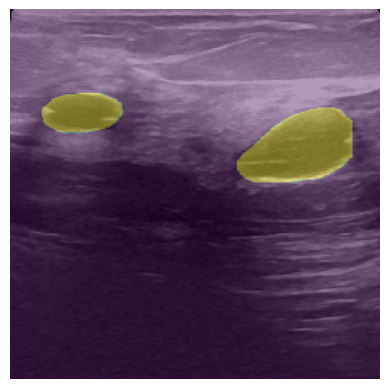

In [37]:
show_image(load_image('/content/drive/MyDrive/Dataset_BUSI_with_GT/benign/benign (100).png', SIZE))
plt.imshow(img, alpha=0.4)
plt.axis('off')
plt.show()

In [38]:
images = load_images(image_paths, SIZE)
masks = load_images(mask_paths, SIZE, mask=True)

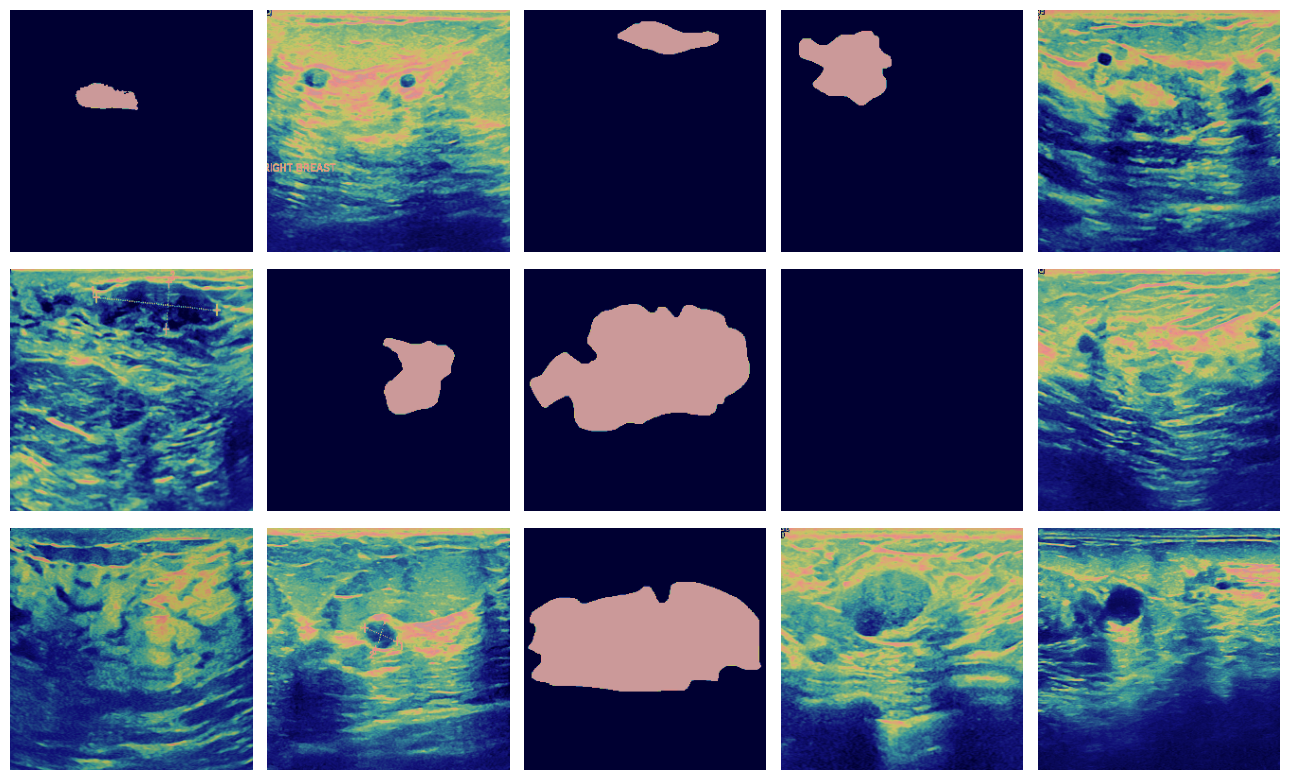

In [39]:
plt.figure(figsize=(13,8))
for i in range(15):
    plt.subplot(3,5,i+1)
    id = np.random.randint(len(images))
    show_mask(images[id], masks[id], cmap='jet')
plt.tight_layout()
plt.show()

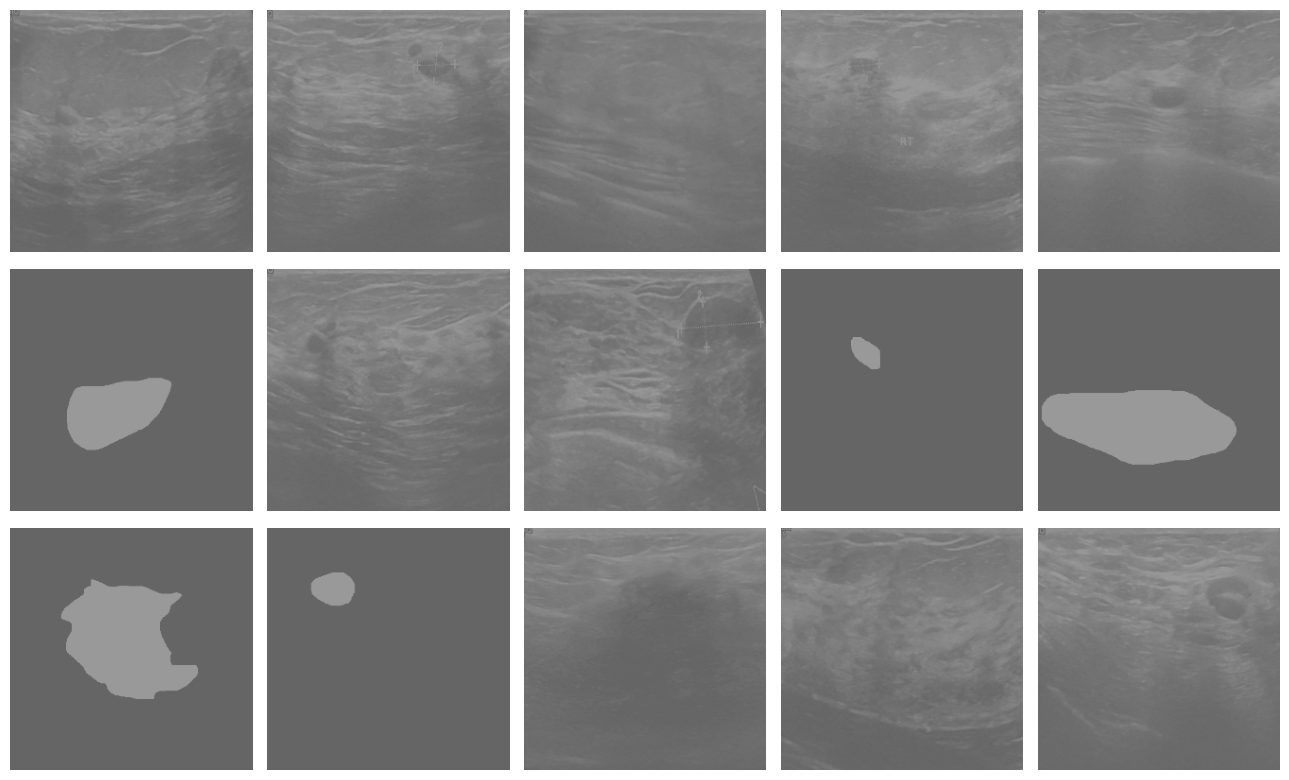

In [40]:
plt.figure(figsize=(13,8))
for i in range(15):
    plt.subplot(3,5,i+1)
    id = np.random.randint(len(images))
    show_mask(images[id], masks[id], cmap='binary')
plt.tight_layout()
plt.show()

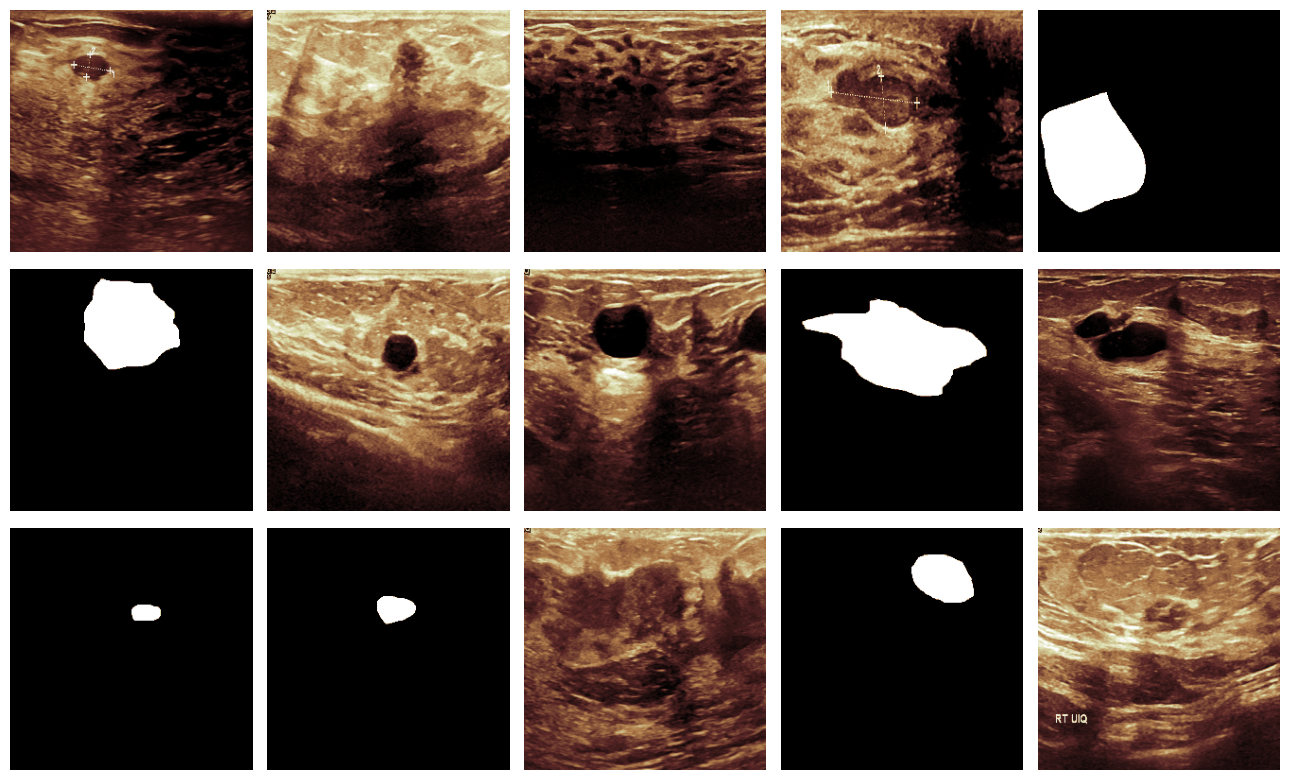

In [41]:
plt.figure(figsize=(13,8))
for i in range(15):
    plt.subplot(3,5,i+1)
    id = np.random.randint(len(images))
    show_mask(images[id], masks[id], cmap='afmhot')
plt.tight_layout()
plt.show()

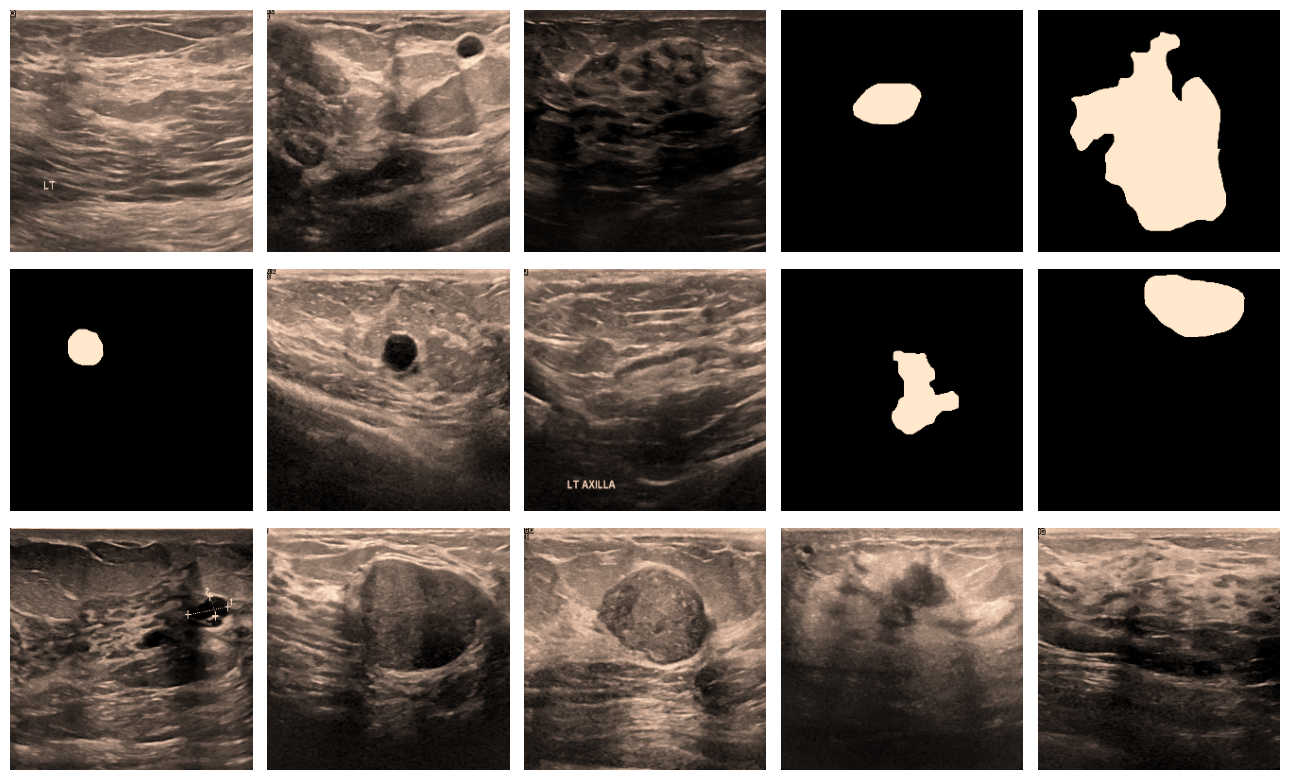

In [42]:
plt.figure(figsize=(13,8))
for i in range(15):
    plt.subplot(3,5,i+1)
    id = np.random.randint(len(images))
    show_mask(images[id], masks[id], cmap='copper')
plt.tight_layout()
plt.show()

In [43]:
class EncoderBlock(Layer):

    def __init__(self, filters, rate, pooling=True, **kwargs):
        super(EncoderBlock, self).__init__(**kwargs)

        self.filters = filters
        self.rate = rate
        self.pooling = pooling

        self.c1 = Conv2D(filters, kernel_size=3, strides=1, padding='same', activation='relu', kernel_initializer='he_normal')
        self.drop = Dropout(rate)
        self.c2 = Conv2D(filters, kernel_size=3, strides=1, padding='same', activation='relu', kernel_initializer='he_normal')
        self.pool = MaxPool2D()

    def call(self, X):
        x = self.c1(X)
        x = self.drop(x)
        x = self.c2(x)
        if self.pooling:
            y = self.pool(x)
            return y, x
        else:
            return x

    def get_config(self):
        base_config = super().get_config()
        return {
            **base_config,
            "filters":self.filters,
            'rate':self.rate,
            'pooling':self.pooling
        }

In [44]:
class DecoderBlock(Layer):

    def __init__(self, filters, rate, **kwargs):
        super(DecoderBlock, self).__init__(**kwargs)

        self.filters = filters
        self.rate = rate

        self.up = UpSampling2D()
        self.net = EncoderBlock(filters, rate, pooling=False)

    def call(self, X):
        X, skip_X = X
        x = self.up(X)
        c_ = concatenate([x, skip_X])
        x = self.net(c_)
        return x

    def get_config(self):
        base_config = super().get_config()
        return {
            **base_config,
            "filters":self.filters,
            'rate':self.rate,
        }

In [45]:
class AttentionGate(Layer):

    def __init__(self, filters, bn, **kwargs):
        super(AttentionGate, self).__init__(**kwargs)

        self.filters = filters
        self.bn = bn

        self.normal = Conv2D(filters, kernel_size=3, padding='same', activation='relu', kernel_initializer='he_normal')
        self.down = Conv2D(filters, kernel_size=3, strides=2, padding='same', activation='relu', kernel_initializer='he_normal')
        self.learn = Conv2D(1, kernel_size=1, padding='same', activation='sigmoid')
        self.resample = UpSampling2D()
        self.BN = BatchNormalization()

    def call(self, X):
        X, skip_X = X

        x = self.normal(X)
        skip = self.down(skip_X)
        x = Add()([x, skip])
        x = self.learn(x)
        x = self.resample(x)
        f = Multiply()([x, skip_X])
        if self.bn:
            return self.BN(f)
        else:
            return f
        # return f

    def get_config(self):
        base_config = super().get_config()
        return {
            **base_config,
            "filters":self.filters,
            "bn":self.bn
        }

In [46]:
class ShowProgress(Callback):
    def on_epoch_end(self, epochs, logs=None):
        id = np.random.randint(200)
        exp = GradCAM()
        image = images[id]
        mask = masks[id]
        pred_mask = self.model.predict(image[np.newaxis,...])
        cam = exp.explain(
            validation_data=(image[np.newaxis,...], mask),
            class_index=1,
            layer_name='Attention4',
            model=self.model
        )

        plt.figure(figsize=(10,5))

        plt.subplot(1,3,1)
        plt.title("Original Mask")
        show_mask(image, mask, cmap='copper')

        plt.subplot(1,3,2)
        plt.title("Predicted Mask")
        show_mask(image, pred_mask, cmap='copper')

        plt.subplot(1,3,3)
        show_image(cam,title="GradCAM")

        plt.tight_layout()
        plt.show()

In [47]:
# Inputs
input_layer = Input(shape=images.shape[-3:])

# Encoder
p1, c1 = EncoderBlock(32,0.1, name="Encoder1")(input_layer)
p2, c2 = EncoderBlock(64,0.1, name="Encoder2")(p1)
p3, c3 = EncoderBlock(128,0.2, name="Encoder3")(p2)
p4, c4 = EncoderBlock(256,0.2, name="Encoder4")(p3)

# Encoding
encoding = EncoderBlock(512,0.3, pooling=False, name="Encoding")(p4)

# Attention + Decoder

a1 = AttentionGate(256, bn=True, name="Attention1")([encoding, c4])
d1 = DecoderBlock(256,0.2, name="Decoder1")([encoding, a1])

a2 = AttentionGate(128, bn=True, name="Attention2")([d1, c3])
d2 = DecoderBlock(128,0.2, name="Decoder2")([d1, a2])

a3 = AttentionGate(64, bn=True, name="Attention3")([d2, c2])
d3 = DecoderBlock(64,0.1, name="Decoder3")([d2, a3])


a4 = AttentionGate(32, bn=True, name="Attention4")([d3, c1])
d4 = DecoderBlock(32,0.1, name="Decoder4")([d3, a4])

# Output
output_layer = Conv2D(1, kernel_size=1, activation='sigmoid', padding='same')(d4)

# Model
model = Model(
    inputs=[input_layer],
    outputs=[output_layer]
)

# Compile
model.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['accuracy', MeanIoU(num_classes=2, name='IoU')]
)

# Callbacks
cb = [
    # EarlyStopping(patience=3, restore_best_weight=True), # With Segmentation I trust on eyes rather than on metrics
    ModelCheckpoint("AttentionCustomUNet.h5", save_best_only=True),
    ShowProgress()
]

In [49]:
inputs = keras.Input(shape=(256, 256, 3))  # Define input layer properly

In [3]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.models import load_model
from google.colab import drive



# Define dataset path
dataset_path = "/content/drive/MyDrive/Dataset_BUSI_with_GT"

# Define image size and categories
IMG_SIZE = (256, 256)  # Resize images to 256x256
categories = ["benign", "malignant", "normal"]

# Load images and masks
def load_dataset():
    images = []
    masks = []

    for category in categories:
        category_path = os.path.join(dataset_path, category)
        mask_path = os.path.join(dataset_path, category)  # Assuming masks are in the same structure

        for file_name in os.listdir(category_path):
            if "mask" in file_name:  # Skip mask files while loading images
                continue

            # Load image
            image = load_img(os.path.join(category_path, file_name), target_size=IMG_SIZE)
            image = img_to_array(image) / 255.0  # Normalize
            images.append(image)

            # Load corresponding mask
            mask_name = file_name.replace(".png", "_mask.png")  # Assuming mask names follow this pattern
            mask = load_img(os.path.join(mask_path, mask_name), target_size=IMG_SIZE, color_mode="grayscale")
            mask = img_to_array(mask) / 255.0  # Normalize
            masks.append(mask)

    return np.array(images), np.array(masks)

# Load the dataset
images, masks = load_dataset()
print(f"Loaded {len(images)} images and {len(masks)} masks.")

# Define batch size and steps per epoch
BATCH_SIZE = 8
steps_per_epoch = max(1, len(images) // BATCH_SIZE)

# Train the model
results = model.fit(
    images, masks,
    validation_split=0.2,  # 20% validation
    epochs=20,  # Train for 20 epochs
    batch_size=BATCH_SIZE,
    steps_per_epoch=steps_per_epoch,
    callbacks=cb  # Callbacks for model checkpoint and visualization
)

# Save the trained model to Google Drive
model.save("/content/drive/MyDrive/Attention_UNet_BreastCancer.h5")

print("Model saved successfully to Google Drive!")

Loaded 780 images and 780 masks.


NameError: name 'model' is not defined

In [4]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

# Define dataset path
dataset_path = "/content/drive/MyDrive/Dataset_BUSI_with_GT"

# Define image size and categories
IMG_SIZE = (256, 256)
categories = ["benign", "malignant", "normal"]

# Load dataset function
def load_dataset():
    images, masks = [], []

    for category in categories:
        category_path = os.path.join(dataset_path, category)

        for file_name in os.listdir(category_path):
            if "mask" in file_name:  # Skip masks while loading images
                continue

            # Load image
            image = load_img(os.path.join(category_path, file_name), target_size=IMG_SIZE)
            image = img_to_array(image) / 255.0  # Normalize
            images.append(image)

            # Load corresponding mask
            mask_name = file_name.replace(".png", "_mask.png")  # Assuming mask names follow this pattern
            mask_path = os.path.join(category_path, mask_name)
            if os.path.exists(mask_path):
                mask = load_img(mask_path, target_size=IMG_SIZE, color_mode="grayscale")
                mask = img_to_array(mask) / 255.0  # Normalize
                masks.append(mask)
            else:
                print(f"Mask not found for: {file_name}")  # Debugging message

    return np.array(images), np.array(masks)

# Load images and masks
images, masks = load_dataset()
print(f"Loaded {len(images)} images and {len(masks)} masks.")

# Define Attention U-Net Model
def build_unet(input_shape=(256, 256, 3)):
    inputs = Input(shape=input_shape)

    # Encoder
    def encoder_block(x, filters):
        x = Conv2D(filters, (3, 3), activation='relu', padding='same')(x)
        x = Dropout(0.1)(x)
        x = Conv2D(filters, (3, 3), activation='relu', padding='same')(x)
        p = MaxPooling2D((2, 2))(x)
        return p, x

    p1, c1 = encoder_block(inputs, 32)
    p2, c2 = encoder_block(p1, 64)
    p3, c3 = encoder_block(p2, 128)
    p4, c4 = encoder_block(p3, 256)

    # Bottleneck
    bn = Conv2D(512, (3, 3), activation='relu', padding='same')(p4)

    # Decoder
    def decoder_block(x, skip, filters):
        x = UpSampling2D((2, 2))(x)
        x = concatenate([x, skip])
        x = Conv2D(filters, (3, 3), activation='relu', padding='same')(x)
        return x

    d1 = decoder_block(bn, c4, 256)
    d2 = decoder_block(d1, c3, 128)
    d3 = decoder_block(d2, c2, 64)
    d4 = decoder_block(d3, c1, 32)

    outputs = Conv2D(1, (1, 1), activation='sigmoid')(d4)

    model = Model(inputs, outputs)
    return model

# Build and compile the model
model = build_unet()
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Define callbacks
checkpoint_path = "/content/drive/MyDrive/Attention_UNet_BreastCancer.h5"
callbacks = [ModelCheckpoint(checkpoint_path, save_best_only=True)]

# Training parameters
BATCH_SIZE = 8
steps_per_epoch = max(1, len(images) // BATCH_SIZE)

# Train the model
results = model.fit(
    images, masks,
    validation_split=0.2,  # 20% validation
    epochs=20,  # Train for 20 epochs
    batch_size=BATCH_SIZE,
    steps_per_epoch=steps_per_epoch,
    callbacks=callbacks
)

# Save the model
model.save(checkpoint_path)
print(f"Model saved successfully!")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Loaded 780 images and 780 masks.
Epoch 1/20
78/97 ━━━━━━━━━━━━━━━━━━━━ 2s 119ms/step - accuracy: 0.9124 - loss: 0.7528

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


97/97 ━━━━━━━━━━━━━━━━━━━━ 50s 215ms/step - accuracy: 0.9116 - loss: 0.6895 - val_accuracy: 0.9811 - val_loss: 0.1072
Epoch 2/20
97/97 ━━━━━━━━━━━━━━━━━━━━ 11s 109ms/step - accuracy: 0.9085 - loss: 0.2633 - val_accuracy: 0.9811 - val_loss: 0.1582
Epoch 3/20
97/97 ━━━━━━━━━━━━━━━━━━━━ 10s 104ms/step - accuracy: 0.9060 - loss: 0.2405 - val_accuracy: 0.9808 - val_loss: 0.1192
Epoch 4/20
97/97 ━━━━━━━━━━━━━━━━━━━━ 11s 110ms/step - accuracy: 0.9102 - loss: 0.2341 - val_accuracy: 0.9802 - val_loss: 0.1252
Epoch 5/20
78/97 ━━━━━━━━━━━━━━━━━━━━ 2s 121ms/step - accuracy: 0.9113 - loss: 0.2302

97/97 ━━━━━━━━━━━━━━━━━━━━ 21s 114ms/step - accuracy: 0.9116 - loss: 0.2302 - val_accuracy: 0.9803 - val_loss: 0.1058
Epoch 6/20
97/97 ━━━━━━━━━━━━━━━━━━━━ 20s 106ms/step - accuracy: 0.9172 - loss: 0.2229 - val_accuracy: 0.9808 - val_loss: 0.1100
Epoch 7/20
97/97 ━━━━━━━━━━━━━━━━━━━━ 21s 114ms/step - accuracy: 0.9162 - loss: 0.2266 - val_accuracy: 0.9811 - val_loss: 0.1818
Epoch 8/20
97/97 ━━━━━━━━━━━━━━━━━━━━ 20s 107ms/step - accuracy: 0.9124 - loss: 0.2362 - val_accuracy: 0.9784 - val_loss: 0.1397
Epoch 9/20
97/97 ━━━━━━━━━━━━━━━━━━━━ 10s 107ms/step - accuracy: 0.9153 - loss: 0.2346 - val_accuracy: 0.9808 - val_loss: 0.1295
Epoch 10/20
78/97 ━━━━━━━━━━━━━━━━━━━━ 2s 124ms/step - accuracy: 0.9185 - loss: 0.2125

97/97 ━━━━━━━━━━━━━━━━━━━━ 22s 122ms/step - accuracy: 0.9186 - loss: 0.2128 - val_accuracy: 0.9811 - val_loss: 0.0833
Epoch 11/20
97/97 ━━━━━━━━━━━━━━━━━━━━ 19s 109ms/step - accuracy: 0.9236 - loss: 0.2110 - val_accuracy: 0.9822 - val_loss: 0.1024
Epoch 12/20
97/97 ━━━━━━━━━━━━━━━━━━━━ 20s 108ms/step - accuracy: 0.9206 - loss: 0.2103 - val_accuracy: 0.9774 - val_loss: 0.1081
Epoch 13/20
97/97 ━━━━━━━━━━━━━━━━━━━━ 20s 108ms/step - accuracy: 0.9289 - loss: 0.1884 - val_accuracy: 0.9814 - val_loss: 0.1129
Epoch 14/20
97/97 ━━━━━━━━━━━━━━━━━━━━ 11s 109ms/step - accuracy: 0.9310 - loss: 0.1835 - val_accuracy: 0.9580 - val_loss: 0.1385
Epoch 15/20
78/97 ━━━━━━━━━━━━━━━━━━━━ 2s 125ms/step - accuracy: 0.9264 - loss: 0.1890

97/97 ━━━━━━━━━━━━━━━━━━━━ 21s 117ms/step - accuracy: 0.9274 - loss: 0.1871 - val_accuracy: 0.9827 - val_loss: 0.0776
Epoch 16/20
97/97 ━━━━━━━━━━━━━━━━━━━━ 20s 108ms/step - accuracy: 0.9409 - loss: 0.1631 - val_accuracy: 0.9717 - val_loss: 0.1348
Epoch 17/20
78/97 ━━━━━━━━━━━━━━━━━━━━ 2s 126ms/step - accuracy: 0.9349 - loss: 0.1762

97/97 ━━━━━━━━━━━━━━━━━━━━ 12s 119ms/step - accuracy: 0.9356 - loss: 0.1746 - val_accuracy: 0.9825 - val_loss: 0.0747
Epoch 18/20
97/97 ━━━━━━━━━━━━━━━━━━━━ 11s 110ms/step - accuracy: 0.9420 - loss: 0.1565 - val_accuracy: 0.9831 - val_loss: 0.1048
Epoch 19/20
78/97 ━━━━━━━━━━━━━━━━━━━━ 2s 124ms/step - accuracy: 0.9432 - loss: 0.1536

97/97 ━━━━━━━━━━━━━━━━━━━━ 21s 116ms/step - accuracy: 0.9434 - loss: 0.1538 - val_accuracy: 0.9844 - val_loss: 0.0643
Epoch 20/20
97/97 ━━━━━━━━━━━━━━━━━━━━ 11s 109ms/step - accuracy: 0.9405 - loss: 0.1606 - val_accuracy: 0.9752 - val_loss: 0.0928


Model saved successfully!
